# Quantum optimization lab

_prepared by Ondřej Král_

<img src="../images/logo-ibm.png" width="130px">

## Setup

In [ ]:
# Install dependencies
%pip install numpy --quiet
%pip install scipy --quiet
%pip install networkx --quiet
%pip install qiskit_optimization --quiet
%pip install qiskit_algorithms --quiet
%pip install matplotlib --quiet
%pip install qiskit[visualization] --quiet

In [ ]:
# Imports and dependencies

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.optimize import minimize


from qiskit.visualization import plot_distribution
from qiskit.circuit.library import TwoLocal, QAOAAnsatz
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler, Estimator
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.quantum_info import SparsePauliOp

## Quantum approximate optimization algorithm for MaxCut

One of the tasks used as a benchmark for quantum algorithms is the MaxCut problem. Given a undirected edge-weighted graph, the objective is to find a bipartition of the graph vertices, i.e. a cut, such that the total weight of cut edges is maximized while each vertex of the graph graph belongs only to one side of the cut (sets of vertices on both sides of the cut are complementaary). See the example below: 

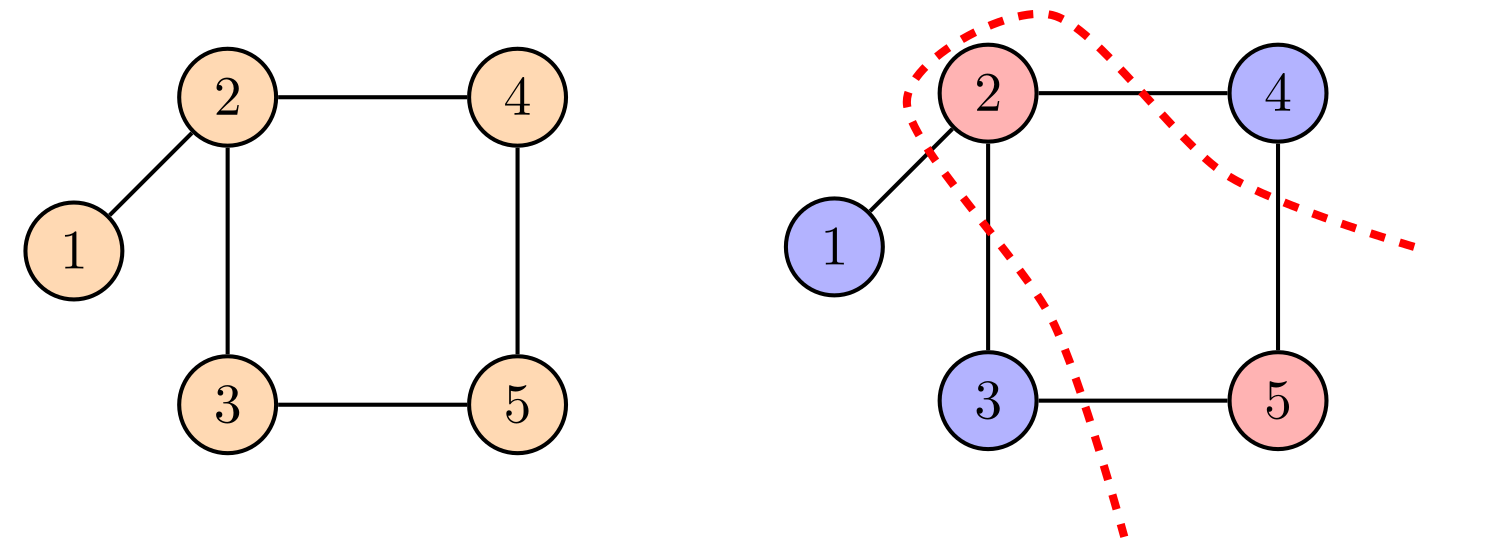

In [ ]:
SEED = 42

In [ ]:
# Generate a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

### Task 1

The QAOA algorithm relies on two unitary operators, the phase operator which encodes the problem cost function and the mixing unitary. For the MaxCut problem these take the following forms:
$$
U(\gamma) = \exp \left(\sum_{u,v}\frac{1}{2}(1-Z_u Z_v)\right)
$$
$$
U(\beta) = \prod_i \exp\left(-\mathrm{i} \beta X_i\right)=\prod_i \left(R_x(2\beta)\right)_i
$$
We already know how to work with the mixing unitary, but the phase unitary needs to be calculated for our graph. Your task is to prepare a list of operators consisting of Pauli $Z$ operators and identities $I$,
so that for each edge there is a pair of $Z$s and $I$s for the rest of edges.
<details>
  <summary>HINT</summary>

  Example: If there is an edge connecting vertices 1 and 3 than we add to our list `"IZIZ"`

</details>

In [ ]:
# TODO
edgez = ["IIZZ", "IZZI", "ZIIZ", "ZIZI", "ZZII"]

In [ ]:
# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([(stringz, 1) for stringz in edgez])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

### Task 2:
At the core of the QAOA algorithms lies an optimization loop. Thus the next step is to define the cost function. Cost is the expectation value
$$
\text{Cost}(\vec{\theta}) = \langle \text{Ansatz} (\vec{\theta}) \lvert \text{Hamiltonian operator}\rvert \text{Ansatz}(\vec{\theta})\rangle
$$
We can get this value by using an `Estimator`, specifiacally by using its method `run()`. The `run` method needs to be supplied with our ansatz circuit, the hamiltonian operator, and finally assign the `paramater_values`.
The `run` method does not return the value, we are looking for directly, but rather a `job`. The cost value is retrieved from a `job` by doing `job.result().values[0]`.

In [ ]:
# Initialize estimator
estimator = Estimator()

In [ ]:
# TODO
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In the next step we move towards the minimization itself.

In [ ]:
# Randomly initialise the parameters
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

In [ ]:
# Minimize with SciPy
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")

In [ ]:
# Print result
res

### Task 3:
To read off the optimial cut, we need to run the ansatz circuit one more time. However, this time using a `Sampler` because, we are no longer *estimating* an operator, but rather *sampling* the binary results.
The meaning of the binary strings is simple, $0$ at $i$th position means that $i$th vertex belongs to the first group of vertices and $1$ at $ij$th position means that $j$th vertex belongs to the second group of vertices.

Create a new circut `qc` from the `ansatz` circuit by assigning the optimal parameters stored in `res.x` using circuit method `assign_parameters`.

In [ ]:
# TODO
qc = ansatz.assign_parameters(res.x)

In [ ]:
# Add measurements to our circuit
qc.measure_all()

In [ ]:
# Initialise Sampler and get the result distribution.
sampler = Sampler()
samp_dist = sampler.run(qc).result().quasi_dists[0]
samp_dist = samp_dist.nearest_probability_distribution()

In [ ]:
# Plot the histogram
plot_distribution(samp_dist.binary_probabilities(), figsize=(15, 5))

### Task 4
Identify the optimal string from the histogram and write it as a string into `optimal_string`.

<details>
  <summary>HINT</summary>

    The optimal strings have the highest probability. There are two of them, but they differ only in the 

</details>

In [ ]:
optimal_string = "0101"

In [ ]:
optimal_color = []
for val in optimal_string:
    if (val == '0'):
        col = 'r'
    else:
        col = 'c'
    optimal_color.append(col)
draw_graph(G, optimal_color, pos)

## VQE and weighted graph

The previously solved graph had same weights for all edges. But this form of solution is not limited to this type of graphs.
For the solution of the problem with weighted graph we use the Variational Quantum Eigensolver.
This is a reminder that QAOA is just one specific configuration of a VQE.

In [ ]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 2.0), (0, 3, 3.0), (1, 2, 4.0), (2, 3, 5.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [ ]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

To simplify the code a `Maxcut` optimization application class can be used.

In [ ]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

### Task 5:
Use the `to_ising()` method of `qp`, which returns the quadratic problem converted to Ising Hamiltonins. This is an automated version of calculating the $Z$ operator strings from previous task.
The `to_ising()` method returns the operator and an offset, save the to variables `ising` and `offset`

In [ ]:
ising, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(ising))

In the last step we use the SPSA optimizer provided by `qiskit_algorithms` to optimize the VQE circuit constructed by the `SamplingVQE` class.
We chode `TwoLocal` circuit as an *ansatz* to construct the state minimizing the energy of the Hamiltonian.

In [ ]:
Wansatz = TwoLocal(ising.num_qubits, "ry", "cz", reps=5, entanglement="linear")
Wansatz.decompose().draw('mpl', style='Clifford')

In [ ]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
vqe = SamplingVQE(sampler=Sampler(), ansatz=Wansatz, optimizer=optimizer)

The VQE finds the minimmum eigenvalue of the Hamiltonian for the system `ising` by using method `compute_minimum_eigenvalue`. 

In [ ]:
# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(ising)

In [ ]:
# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

In [ ]:
# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Making sure our solution is correct
This section should answer the question of correctness of obtained results.

First we check the solution of the quadratic Maxcut problem with a classical eigensolver and optimizer.

In [ ]:
# solving Quadratic Program using exact classical eigensolver
result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
print(result.prettyprint())

Then we check the graph bipartition.

In [ ]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(ising)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

Even though the result is correct, the bipartion can be checked without the 

In [ ]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))